# Preprocessing Workflow Structure

     1. Gunzip (Nipype)
     2. Slice Time Correction (SPM)
     3. Motion Correction (SPM)
     4. Artifact Detection
     5. Segmentation (SPM)
     6. Coregistration (FSL)
     7. Smoothing (FSL)
     8. Apply Binary Mask (FSL)
     9. Remove Linear Trends (Nipype)
    

try freesurfer in initial task

change to BIDS format

## Imports

It's always best to have all relevant module imports at the beginning of your script. So let's import what we most certainly need.

In [1]:
from nilearn import plotting
%matplotlib inline
import nibabel as nib
import matplotlib.pyplot as plt

# Get the Node and Workflow object
from nipype import Node, Workflow
from nipype.algorithms.misc import Gunzip

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/Downloads/spm12')

/Users/keshvigupta/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Note:** Ideally you would also put the imports of all the interfaces that you use here at the top. But as we will develop the workflow step by step, we can also import the relevant modules as we go.

## Create Nodes and Workflow connections

Let's create all the nodes that we need.

### Workflow

In [2]:
preproc = Workflow(name='work_preproc', base_dir='/output/')

### Gunzip

In [3]:
func_file = "../AA_041/AA_041_7_MB_Resting.nii.gz"

# Initiate Gunzip node
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

In [4]:
img_bold = nib.load(func_file)
data_bold = img_bold.get_fdata()
data_bold.shape

(116, 116, 45, 812)

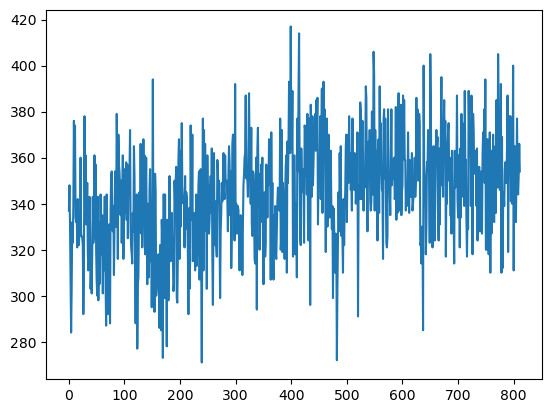

In [5]:
plt.plot(data_bold[80, 50, 20, :])
plt.show()

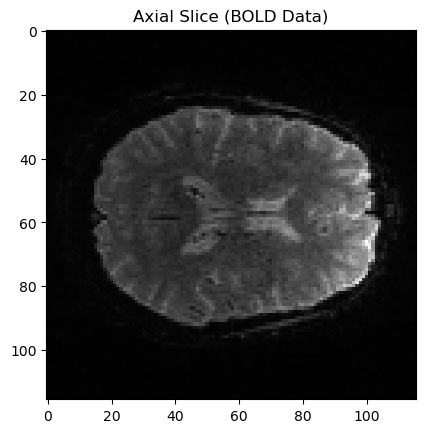

In [6]:
bold_slice = data_bold[:, :, data_bold.shape[2] // 2, data_bold.shape[3] // 2]

plt.imshow(bold_slice, cmap='gray')
plt.title('Axial Slice (BOLD Data)')
plt.show()

### Slice Time Correction

In [7]:
from nipype.interfaces.spm import SliceTiming

In [8]:
slice_order = list(range(1, 31, 2)) + list(range(2, 31, 2))
print(slice_order)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


In [9]:
slicetime = Node(SliceTiming(num_slices=30,
                             ref_slice=15,
                             slice_order=slice_order,
                             time_repetition=2.5,
                             time_acquisition=2.5-(2.5/30)),
                 name='slicetime')

In [10]:
preproc.connect([(gunzip_func, slicetime, [('out_file', 'in_files')])])

### Motion Correction

To correct for motion in the scanner, we will be using FSL's `MCFLIRT`.

In [11]:
from nipype.interfaces.fsl import MCFLIRT

In [12]:
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name="mcflirt")

Connect the `MCFLIRT` node to the rest of the workflow.

In [13]:
preproc.connect([(slicetime, mcflirt, [('timecorrected_files', 'in_file')])])

### Artifact Detection

In [14]:
from nipype.algorithms.rapidart import ArtifactDetect

In [15]:
# use 0.3 threshold
art = Node(ArtifactDetect(norm_threshold=0.3,
                          zintensity_threshold=2.2,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

In [16]:
preproc.connect([(mcflirt, art, [('out_file', 'realigned_files'),
                                 ('par_file', 'realignment_parameters')])
                 ])

### Segmentation of anatomical image

Now let's work on the anatomical image. In particular, let's use SPM's `NewSegment` to create probability maps for the gray matter, white matter tissue and CSF.

In [18]:
from nipype.interfaces.spm import NewSegment

In [19]:
# Use the following tissue specification to get a GM and WM probability map
tpm_img ='/Users/keshvigupta/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True,False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True,False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True,False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False,False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False,False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False,False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]

In [20]:
# Initiate NewSegment node here

In [21]:
segment = Node(NewSegment(tissues=tissues), name='segment')

We will again be using a `Gunzip` node to unzip the anatomical image that we then want to use as input to the segmentation node. We again also need to specify the anatomical image that we want to use in this case. As before, this will later also be handled directly by the Input/Output stream.

In [22]:
# Specify example input file
anat_file = '../AA_041/AA_041_2_MPRAGE_GRAPPA2.nii.gz'

# Initiate Gunzip node
gunzip_anat = Node(Gunzip(in_file=anat_file), name='gunzip_anat')

Now we can connect the `NewSegment` node to the rest of the workflow.

In [23]:
# Connect NewSegment node to the other nodes here

In [24]:
preproc.connect([(gunzip_anat, segment, [('out_file', 'channel_files')])])

### Compute Coregistration Matrix


In [25]:
from nipype.interfaces.fsl import FLIRT

In [26]:
# Initiate FLIRT node here

In [27]:
coreg = Node(FLIRT(dof=6,
                   cost='bbr',
                   schedule='/Users/keshvigupta/fsl/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'),
             name="coreg")

In [28]:
# Connect FLIRT node to the other nodes here

In [29]:
preproc.connect([(gunzip_anat, coreg, [('out_file', 'reference')]),
                 (mcflirt, coreg, [('mean_img', 'in_file')])
                 ])

In [30]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                              args='-bin',
                              output_type='NIFTI'),
                name="threshold_WM")

In [31]:
# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[1][0]

# Connecting the segmentation node with the threshold node
preproc.connect([(segment, threshold_WM, [(('native_class_images', get_wm),
                                           'in_file')])])

Now we can just connect this `Threshold` node to the coregistration node from above.

In [32]:
# Connect Threshold node to coregistration node above here

In [33]:
preproc.connect([(threshold_WM, coreg, [('out_file', 'wm_seg')])])

In [34]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

In [35]:
# Connecting the ApplyWarp node to all the other nodes
preproc.connect([(mcflirt, applywarp, [('out_file', 'in_file')]),
                 (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (gunzip_anat, applywarp, [('out_file', 'reference')])
                 ])

### Smoothing

In [37]:
from niflow.nipype1.workflows.fmri.fsl.preprocess import create_susan_smooth

In [38]:
# Initiate SUSAN workflow here

In [39]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 4

In [40]:
# Connect Threshold node to coregistration node above here

In [41]:
preproc.connect([(applywarp, susan, [('out_file', 'inputnode.in_files')])])

### Create Binary Mask

In [42]:
from nipype.interfaces.fsl import FLIRT

# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="resample")

In [43]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                         args='-bin -dilF',
                         output_type='NIFTI'),
                name="mask_GM")

# Select GM segmentation file from segmentation output
def get_gm(files):
    return files[0][0]

In [44]:
preproc.connect([(segment, resample, [(('native_class_images', get_gm), 'in_file'),
                                      (('native_class_images', get_gm), 'reference')
                                      ]),
                 (resample, mask_GM, [('out_file', 'in_file')])
                 ])

### Apply the binary mask

In [45]:
preproc.connect([(mask_GM, susan, [('out_file', 'inputnode.mask_file')])])

In [46]:
from nipype.interfaces.fsl import ApplyMask

In [47]:
from nipype import MapNode

In [48]:
mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func", 
                    iterfield=["in_file"])

In [49]:
preproc.connect([(susan, mask_func, [('outputnode.smoothed_files', 'in_file')]),
                 (mask_GM, mask_func, [('out_file', 'mask_file')])
                 ])

### Remove linear trends in functional images

In [50]:
from nipype.algorithms.confounds import TSNR

In [51]:
detrend = Node(TSNR(regress_poly=2), name="detrend")

In [52]:
preproc.connect([(mask_func, detrend, [('out_file', 'in_file')])])